In [1]:
from src.load_balancer.simulation import simulation_cli
import numpy as np

In [2]:
sim = await simulation_cli(num_servers=2,server_buffer_size=2,server_mu=0.04,lambda_=50,simulation_time=3,routing_fn='shortest_queue')


00:00:046 | INFO | [WS2] ✅ Processed request   2 (0.02s)
00:00:047 | INFO | [WS1] ✅ Processed request   0 (0.04s)
00:00:078 | INFO | [WS2] ✅ Processed request   3 (0.03s)
00:00:083 | INFO | [WS2] ✅ Processed request   5 (0.00s)
00:00:087 | INFO | [WS1] ✅ Processed request   1 (0.04s)
00:00:095 | INFO | [WS1] ✅ Processed request   4 (0.01s)
00:00:165 | INFO | [WS1] ✅ Processed request   6 (0.01s)
00:00:176 | INFO | [WS1] ✅ Processed request   7 (0.01s)
00:00:183 | INFO | [WS2] ✅ Processed request   8 (0.03s)
00:00:185 | INFO | [WS1] ✅ Processed request  10 (0.01s)



Start symulacji - polityka route_shortest_queue


00:00:203 | INFO | [WS1] ✅ Processed request  11 (0.00s)
00:00:237 | INFO | [WS2] ✅ Processed request   9 (0.05s)
00:00:286 | INFO | [WS1] ✅ Processed request  12 (0.07s)
00:00:351 | INFO | [WS1] ✅ Processed request  13 (0.06s)
00:00:369 | INFO | [WS1] ✅ Processed request  14 (0.02s)
00:00:418 | INFO | [WS1] ❌ Rejected  request  21 (queue full)
00:00:430 | INFO | [WS1] ✅ Processed request  17 (0.06s)
00:00:471 | INFO | [WS1] ✅ Processed request  18 (0.04s)
00:00:472 | INFO | [WS1] ✅ Processed request  19 (0.00s)
00:00:474 | INFO | [WS2] ✅ Processed request  15 (0.15s)
00:00:505 | INFO | [WS1] ✅ Processed request  22 (0.03s)
00:00:520 | INFO | [WS2] ✅ Processed request  16 (0.05s)
00:00:545 | INFO | [WS2] ✅ Processed request  20 (0.02s)
00:00:573 | INFO | [WS1] ❌ Rejected  request  29 (queue full)
00:00:607 | INFO | [WS1] ❌ Rejected  request  30 (queue full)
00:00:629 | INFO | [WS2] ✅ Processed request  25 (0.08s)
00:00:662 | INFO | [WS1] ✅ Processed request  23 (0.15s)
00:00:674 | INFO


Polityka: route_shortest_queue
Przetworzone zgłoszenia: 128
Odrzucone zgłoszenia: 9
Zgłoszenia w kolejkach: 1


In [3]:
import json
import pandas as pd

def process_queue_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
    
    data_df = pd.DataFrame(data)
    
    def convert_to_ms(timestamp):
        m, s, ms = timestamp.split(':')
        total_ms = (int(m) * 60 * 1000) + (int(s) * 1000) + int(ms)
        return round(total_ms, 5)
    
    data_df['ts_in_ms'] = data_df['ts'].apply(convert_to_ms)
    
    queue_count = {}
    
    data_df['currently_in_queue'] = 0

    for index, row in data_df.iterrows():
        source = row['source']
        status = row['status']
        
        if source not in queue_count:
            queue_count[source] = 0
        
        if status == 'queued':
            queue_count[source] += 1
        elif status == 'processed':
            queue_count[source] -= 1
        
        data_df.at[index, 'currently_in_queue'] = queue_count[source]
    
    queued_df = data_df[data_df['status'] == 'queued']
    processed_df = data_df[data_df['status'] == 'processed']
    
    merged_df = pd.merge(queued_df, processed_df, on='request', suffixes=('_queued', '_processed'))
    
    merged_df['processing_time_ms'] = merged_df['ts_in_ms_processed'] - merged_df['ts_in_ms_queued']
    
    result = merged_df[['request', 'ts_queued', 'ts_processed', 'processing_time_ms', 'source_queued']]
    rejects = data_df[data_df['status'] == 'rejected']
    
    return data_df, result, rejects

# Example usage:
file_path = '.logs/route_shortest_queue_0.json'
data_df, result, rejects = process_queue_data(file_path)

print(result)
print(rejects)


     request  ts_queued ts_processed  processing_time_ms source_queued
0          0  00:00:000    00:00:047                  47           WS1
1          1  00:00:011    00:00:087                  76           WS1
2          4  00:00:047    00:00:095                  48           WS1
3          6  00:00:150    00:00:165                  15           WS1
4          7  00:00:151    00:00:176                  25           WS1
..       ...        ...          ...                 ...           ...
123      124  00:02:557    00:02:653                  96           WS2
124      126  00:02:633    00:02:724                  91           WS2
125      130  00:02:710    00:02:743                  33           WS2
126      132  00:02:731    00:02:760                  29           WS2
127      136  00:02:870    00:02:916                  46           WS2

[128 rows x 5 columns]
            ts source  request    status  ts_in_ms  currently_in_queue
23   00:00:418    WS1       21  rejected       418   

In [4]:
df_a = data_df[data_df['source'] == 'WS2']
df_a['ts_in_ms'].values[0] * df_a['ts_in_ms'].values[1]

np.int64(900)

In [5]:
# % zapełnienia kolejki

avg_queue = 0
temp_sum = 0

df_a = data_df[data_df['source'] == 'WS1']
for idx in range(df_a.shape[0]-1):
    temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
temp_sum = temp_sum / df_a['ts_in_ms'].values[-1] / 3
temp_sum


np.float64(0.6408703454463885)

In [6]:

data_df[data_df['source'] == 'WS2']


,ts,source,request,status,ts_in_ms,currently_in_queue
155,00:00:030,WS2,2,queued,30,1
156,00:00:030,WS2,3,queued,30,2
157,00:00:046,WS2,2,processed,46,1
158,00:00:053,WS2,5,queued,53,2
159,00:00:078,WS2,3,processed,78,1
...,...,...,...,...,...,...
263,00:02:743,WS2,130,processed,2743,1
264,00:02:760,WS2,132,processed,2760,0
265,00:02:870,WS2,136,queued,2870,1
266,00:02:916,WS2,136,processed,2916,0


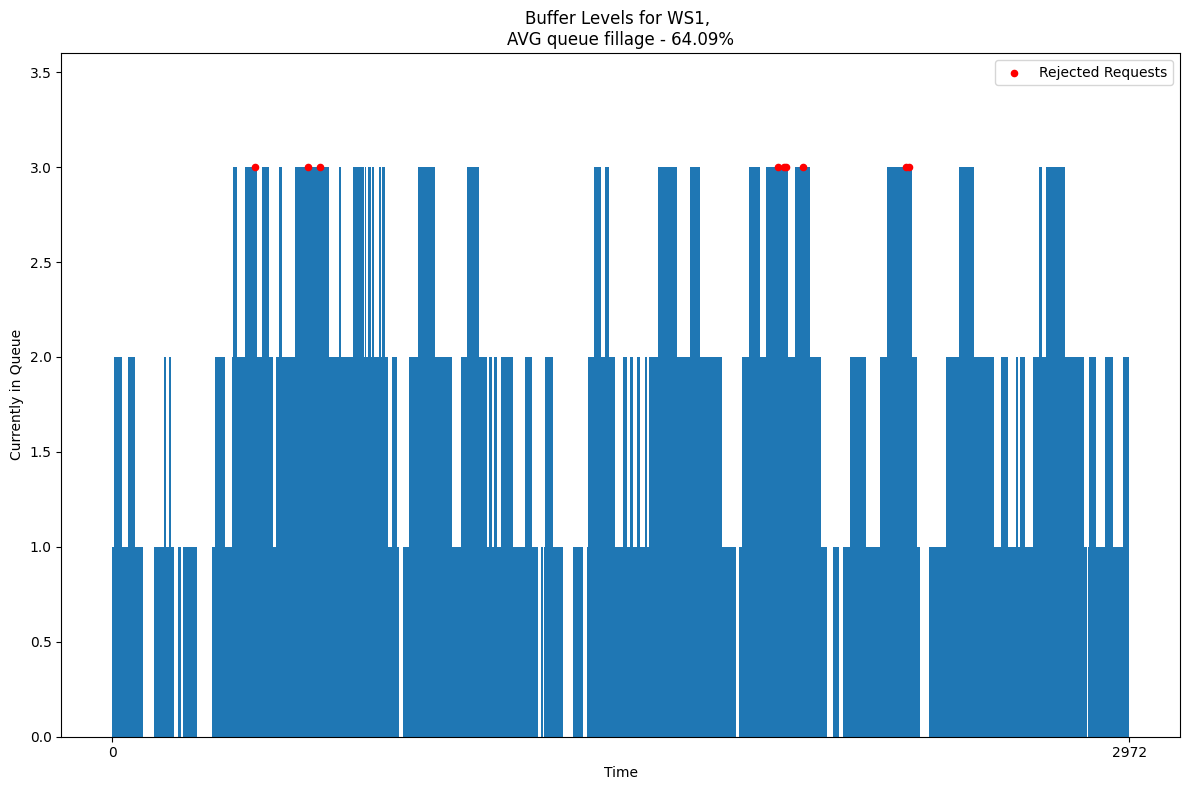

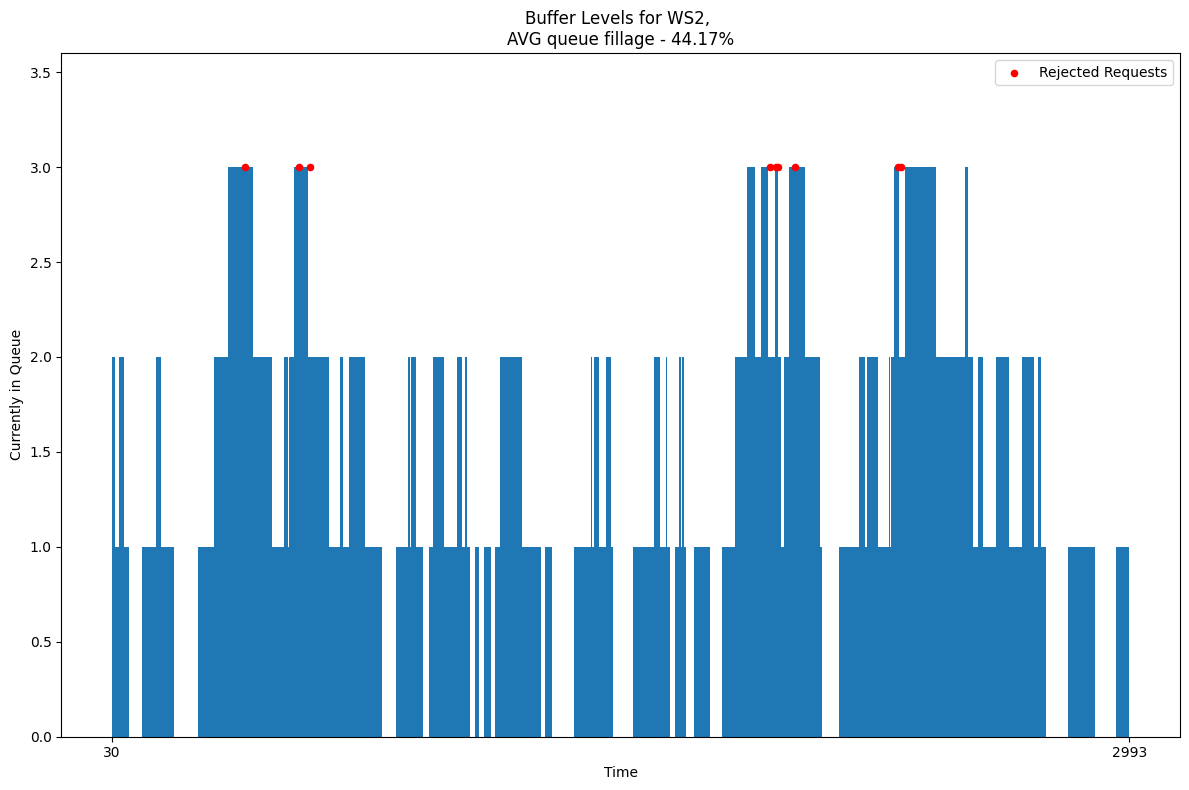

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_buffer_levels(data_df, rejects, max_buffer,plot=True):

    # Get unique sources from the DataFrame
    unique_sources = data_df['source'].unique()
    avg_queues_p = {}
    # Iterate through each source to create the plots
    for source in unique_sources:
        temp_sum = 0
        df_a = data_df[data_df['source'] == source]
        for idx in range(df_a.shape[0]-1):
            temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
        avg_queue_p = np.round(temp_sum / df_a['ts_in_ms'].values[-1] / 3 *100,2)
        avg_queues_p[f'{source}'] =avg_queue_p
        # Filter the data for the current source
        source_data = data_df[data_df['source'] == source]
        if plot:
            # Create a new figure for each source
            plt.figure(figsize=(12, 8))
            
            # Step plot for currently in queue
            plt.step(source_data['ts_in_ms'], source_data['currently_in_queue'], where='mid', alpha=0)
            plt.fill_between(source_data['ts_in_ms'], source_data['currently_in_queue'], step='mid')

            # Set the limits for the y-axis
            plt.ylim(0, max_buffer*1.2)
            
            # Scatter plot for rejected requests
            plt.scatter(rejects['ts_in_ms'], np.ones(len(rejects)) * max_buffer, 
                        color='red', s=20, label='Rejected Requests')

            # Set title and labels
            plt.title(f'Buffer Levels for {source}, \nAVG queue fillage - {avg_queue_p}%')
            plt.xlabel('Time')
            plt.ylabel('Currently in Queue')
            plt.legend()
            
            # Set x-axis ticks
            plt.xticks([np.min(source_data['ts_in_ms']), np.max(source_data['ts_in_ms'])])
            
            # Show the plot
            plt.tight_layout()
            plt.show()
        else:
            return avg_queues_p
# Example usage
max_buffer = 3  # Set the maximum buffer level as needed
plot_buffer_levels(data_df, rejects, max_buffer)


In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_processing_times(merged_df, plot = True):
    unique_sources = merged_df['source_queued'].unique()
    avg_times = {}
    stds_times = {}
    for source in unique_sources:
        avg_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].mean()
        stds_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].std()
    avg_times['Global'] = result['processing_time_ms'].mean()
    stds_times['Global'] = result[result['source_queued']==source]['processing_time_ms'].std()
   
    if plot:
        num_sources = len(unique_sources)
        cmap = cm.get_cmap('tab20', num_sources)  
        color_mapping = {source: cmap(i) for i, source in enumerate(unique_sources)}

        colors = merged_df['source_queued'].map(color_mapping)
    
        fig = plt.figure(figsize=[12, 8])
        plt.bar(merged_df['request'], merged_df['processing_time_ms'], color=colors)

        plt.xlabel('Request ID')
        plt.ylabel('Processing Time (ms)')
        plt.title('Processing Time per Request')
        

        handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[source]) for source in unique_sources]
        plt.legend(handles, unique_sources, title="Source")
        plt.show()
    else:
        return avg_times, stds_times

plot_processing_times(result)

SyntaxError: invalid syntax (41792494.py, line 8)

In [19]:
np.arange(0.01,0.21,0.02)

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19])

In [18]:
reject_percent = {}
avg_times = {}
avg_times_stds = {}
avg_queues_p = {}
max_buffer = 5
times = np.arange(0.01,0.21,0.01)
for start in ['shortest_queue','random']:
    for process_time in times:
        sim = await simulation_cli(num_servers=2,server_buffer_size=max_buffer,server_mu=process_time,lambda_=50,simulation_time=0.5,routing_fn=start, logging=False)
        reject_percent[f'{start}_{process_time}'] = sim.get('total_rejected')/(sim.get('total_processed')+sim.get('total_rejected'))
        file_path = f'.logs/route_{start}_0.json'
        data_df, result, rejects = process_queue_data(file_path)
        avg_times[f'{start}_{process_time}'],avg_times_stds[f'{start}_{process_time}'] =  plot_processing_times(result,plot=False)
        avg_queues_p[f'{start}_{process_time}'] =plot_buffer_levels(data_df, rejects, max_buffer,plot=False)
        


Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 239
Odrzucone zgłoszenia: 0
Zgłoszenia w kolejkach: 1

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 263
Odrzucone zgłoszenia: 0
Zgłoszenia w kolejkach: 0

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 250
Odrzucone zgłoszenia: 1
Zgłoszenia w kolejkach: 1

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 217
Odrzucone zgłoszenia: 18
Zgłoszenia w kolejkach: 0

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 181
Odrzucone zgłoszenia: 49
Zgłoszenia w kolejkach: 8

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 147
Odrzucone zgłoszenia: 75
Zgłoszenia w kolejkach: 8

Start symulacji - polityka route_sho

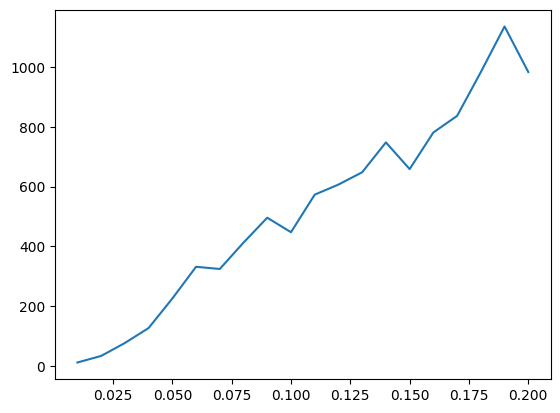

In [28]:
shortest_dict = {key: val for key, val in avg_times.items() if key.startswith('short')}
plt.plot(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(20))

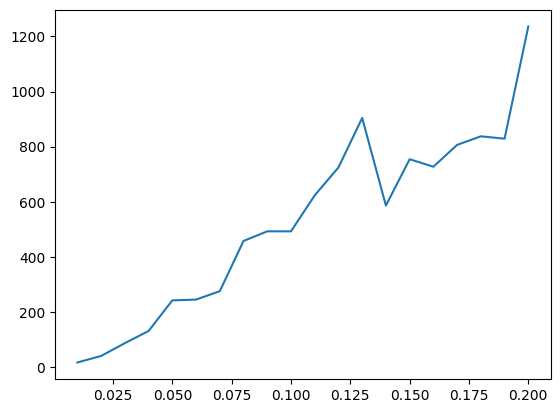

In [30]:
shortest_dict = {key: val for key, val in avg_times.items() if key.startswith('random')}
plt.plot(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(20))

In [29]:
pd.DataFrame.from_dict(shortest_dict)[-1:]

,shortest_queue_0.01,shortest_queue_0.02,shortest_queue_0.03,shortest_queue_0.04,shortest_queue_0.05,shortest_queue_0.06,shortest_queue_0.07,shortest_queue_0.08,shortest_queue_0.09,shortest_queue_0.1,shortest_queue_0.11,shortest_queue_0.12,shortest_queue_0.13,shortest_queue_0.14,shortest_queue_0.15,shortest_queue_0.16,shortest_queue_0.17,shortest_queue_0.18,shortest_queue_0.19,shortest_queue_0.2
Global,11.355649,33.197719,76.52,126.548387,225.276243,331.489796,324.17931,412.385246,495.708738,447.209524,572.844444,606.566265,647.780488,747.676471,658.373333,780.875,836.366667,983.093023,1135.511628,983.104167
